## Text Classification Model Analysis: Attention

In this notebook, we analyze the model to understand the effect of graph convolution on the text classification task.

* Wha kind of graph structure is effective?
  * Node representation
  * Edge definition
* What kind of connection is effective?
  * dependency type etc.

In This notebook, we analyze attention.


In [28]:
import os
import sys
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def set_path():
    root = os.path.join(os.path.realpath("."), "../../")
    if root not in sys.path:
        sys.path.append(root)
    return root

ROOT_DIR = set_path()

## Graph Attention Experiments


We use word embedding only for naked model analysis, and use LSTM(before) that works most effective.


In [31]:
from sklearn.metrics import classification_report
from gcn.data.multi_nli_dataset import MultiNLIDataset
from gcn.classification.trainer import Trainer
from gcn.graph.dependency_graph import DependencyGraph
from gcn.graph.similarity_graph import SimilarityGraph
from gcn.graph.static_graph import StaticGraph
from gcn.classification.graph_based_classifier import GraphBasedClassifier
from gcn.visualize.draw import AttentionDrawer


def experiment(graph_type, head_types=("concat",), head=1,
               epochs=35, sequence_length=25, lstm=None, bidirectional=False):
    dataset = MultiNLIDataset(ROOT_DIR)

    if graph_type == "dependency":
        graph_builder = DependencyGraph(lang="en")
    elif graph_type == "similarity":
        graph_builder = SimilarityGraph(lang="en")
    else:
        graph_builder = StaticGraph(lang="en")

    trainer = Trainer(graph_builder, ROOT_DIR, log_dir="classifier_analysis")
    trainer.build()
    vocab_size = len(trainer.preprocessor.vocabulary.get())
    drawer = AttentionDrawer(trainer.graph_builder)

    def preprocessor(x):
        _x = trainer.preprocess(x, sequence_length)
        values = (_x["text"], _x["graph"])
        return values

    model = GraphBasedClassifier(vocab_size, sequence_length,
                                 head_types=head_types, heads=head,
                                 lstm=lstm, bidirectional=bidirectional)
    model.build(trainer.num_classes, preprocessor)
    metrics = trainer.train(model.model, epochs=epochs, verbose=0)

    result = pd.DataFrame.from_dict(metrics.history)
    result.plot.line(secondary_y=["loss", "val_loss"])

    test_data = dataset.test_data()
    y_pred = model.predict(test_data["text"])

    print(classification_report(test_data["label"], y_pred,
                                target_names=dataset.labels()))
    
    return model, drawer

### Analyze Attention

#### Train the Model

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.27      0.58      0.37       348
  government       0.50      0.45      0.47       348
       slate       0.24      0.35      0.28       348
   telephone       0.54      0.97      0.69       348
      travel       0.62      0.34      0.44       348
  nineeleven       0.81      0.47      0.60       348
  facetoface       0.44      0.65      0.52       348
     letters       0.82      0.40      0.54       348
         oup       0.78      0.19      0.31       348
    verbatim       0.42      0.15      0.22       348

   micro avg       0.46      0.46      0.46      3480
   macro avg       0.54      0.46      0.44      3480
weighted avg       0.54      0.46      0.44      3480



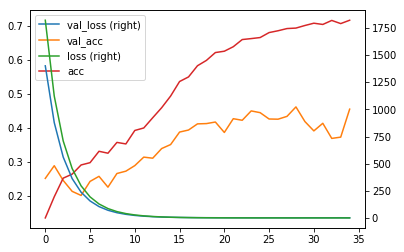

In [32]:
model_d, drawer_d = experiment("dependency", lstm=None)

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.25      0.75      0.38       348
  government       0.69      0.28      0.40       348
       slate       0.26      0.13      0.17       348
   telephone       0.64      0.98      0.77       348
      travel       0.29      0.62      0.40       348
  nineeleven       0.95      0.43      0.59       348
  facetoface       0.59      0.43      0.50       348
     letters       0.74      0.43      0.54       348
         oup       0.83      0.17      0.29       348
    verbatim       0.39      0.18      0.24       348

   micro avg       0.44      0.44      0.44      3480
   macro avg       0.56      0.44      0.43      3480
weighted avg       0.56      0.44      0.43      3480



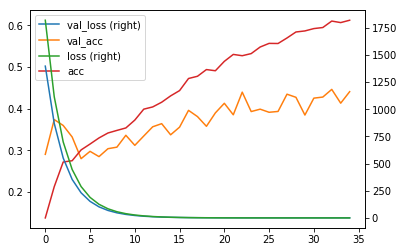

In [33]:
model_s, drawer_s = experiment("similarity", lstm=None)

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.33      0.44      0.38       348
  government       0.67      0.43      0.52       348
       slate       0.22      0.36      0.28       348
   telephone       0.89      0.88      0.89       348
      travel       0.57      0.42      0.48       348
  nineeleven       0.98      0.52      0.68       348
  facetoface       0.38      0.89      0.53       348
     letters       0.76      0.53      0.62       348
         oup       0.83      0.29      0.43       348
    verbatim       0.37      0.28      0.32       348

   micro avg       0.50      0.50      0.50      3480
   macro avg       0.60      0.50      0.51      3480
weighted avg       0.60      0.50      0.51      3480



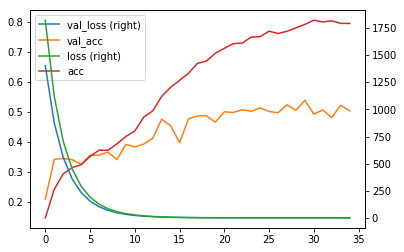

In [34]:
model_st, drawer_st = experiment("static", lstm=None)

#### Show Attention

In [35]:
def show_attention(model, drawer, index=-1, attention_head=0):
    dataset = MultiNLIDataset(ROOT_DIR)
    test_data = dataset.test_data()
    _index = index if index > 0 else np.random.randint(len(test_data), size=1)[0]
    text = test_data["text"].iloc[_index]
    attention = model.show_attention([text])[0][0]  # batch/layer
    nodes = drawer.graph_builder.get_nodes(text)
    
    attention_head = attention_head if isinstance(attention_head, (list, tuple)) else [attention_head]
    for head in attention_head:
        _attention = attention[head]
        if len(nodes) > len(_attention):
            nodes = nodes[:len(_attention)]
        elif len(nodes) < len(_attention[0]):
            _attention = _attention[:len(nodes), :len(nodes)]

        df = pd.DataFrame(_attention, columns=nodes, index=nodes)
        plt.pcolor(df)
        plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
        plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
        plt.show()
        graph = drawer.draw(text, _attention)
        drawer.show(graph)

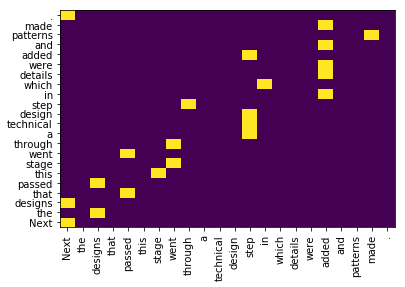

c:\users\ico\documents\works\graph-convolution-nlp\venv\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


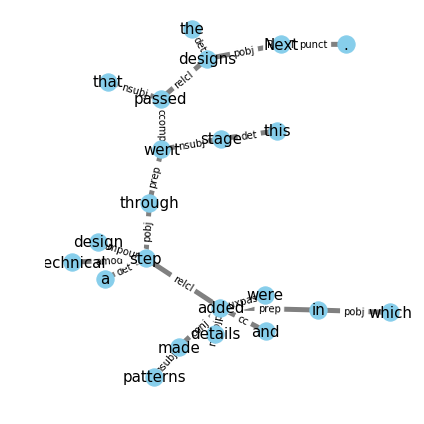

In [36]:
show_attention(model_d, drawer_d)

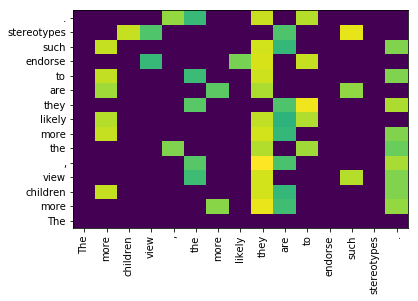

c:\users\ico\documents\works\graph-convolution-nlp\venv\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


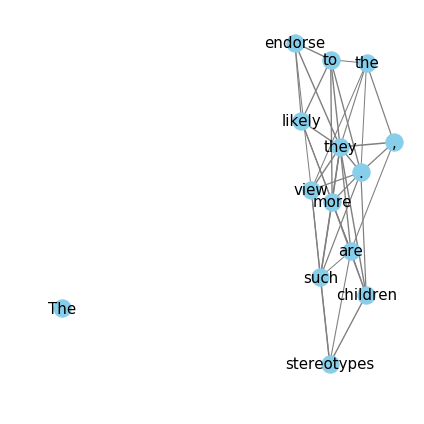

In [37]:
show_attention(model_s, drawer_s)

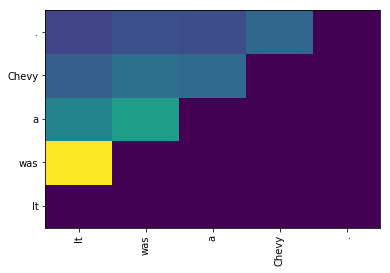

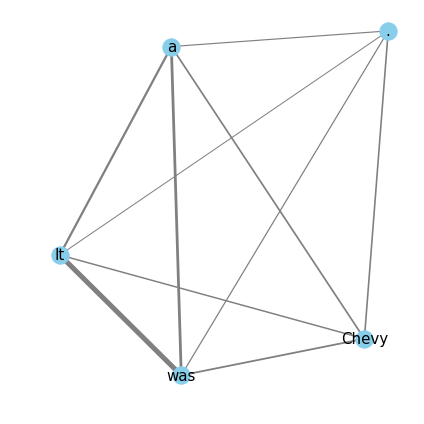

In [38]:
show_attention(model_st, drawer_st)

### Analyze Multi Head Attention

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.24      0.60      0.35       348
  government       0.51      0.38      0.43       348
       slate       0.28      0.20      0.23       348
   telephone       0.44      0.98      0.61       348
      travel       0.53      0.33      0.41       348
  nineeleven       0.70      0.52      0.60       348
  facetoface       0.41      0.57      0.47       348
     letters       0.72      0.41      0.53       348
         oup       0.77      0.19      0.30       348
    verbatim       0.53      0.14      0.23       348

   micro avg       0.43      0.43      0.43      3480
   macro avg       0.51      0.43      0.42      3480
weighted avg       0.51      0.43      0.42      3480



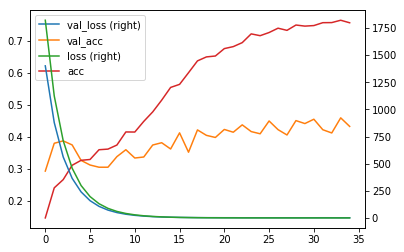

In [39]:
model_d2, drawer_d2 = experiment("dependency", head=2, lstm=None)

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.19      0.59      0.29       348
  government       0.74      0.22      0.34       348
       slate       0.36      0.03      0.05       348
   telephone       0.91      0.89      0.90       348
      travel       0.41      0.37      0.39       348
  nineeleven       0.88      0.43      0.58       348
  facetoface       0.31      0.88      0.46       348
     letters       0.60      0.47      0.53       348
         oup       0.84      0.20      0.32       348
    verbatim       0.50      0.15      0.23       348

   micro avg       0.42      0.42      0.42      3480
   macro avg       0.57      0.42      0.41      3480
weighted avg       0.57      0.42      0.41      3480



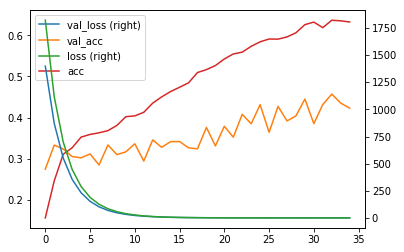

In [40]:
model_s2, drawer_s2 = experiment("similarity", head=2, lstm=None)

Load existing preprocessor preprocessor.pkl.
Read resource from the existed resource(if you want to retry, set force=True).
Read resource from the existed resource(if you want to retry, set force=True).
              precision    recall  f1-score   support

     fiction       0.68      0.36      0.47       348
  government       0.55      0.61      0.58       348
       slate       0.22      0.66      0.33       348
   telephone       0.88      0.94      0.91       348
      travel       0.64      0.24      0.34       348
  nineeleven       0.78      0.65      0.71       348
  facetoface       0.55      0.74      0.63       348
     letters       0.69      0.68      0.68       348
         oup       0.77      0.30      0.43       348
    verbatim       0.40      0.14      0.20       348

   micro avg       0.53      0.53      0.53      3480
   macro avg       0.62      0.53      0.53      3480
weighted avg       0.62      0.53      0.53      3480



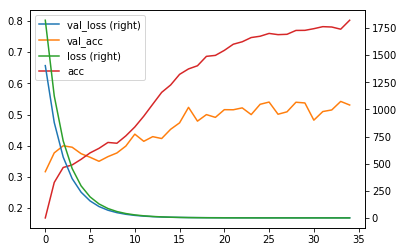

In [41]:
model_st2, drawer_st2 = experiment("static", head=2, lstm=None)

#### Show Attention of Multiple Head


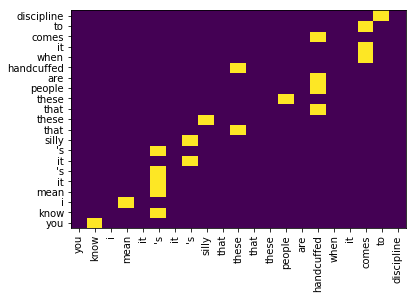

c:\users\ico\documents\works\graph-convolution-nlp\venv\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


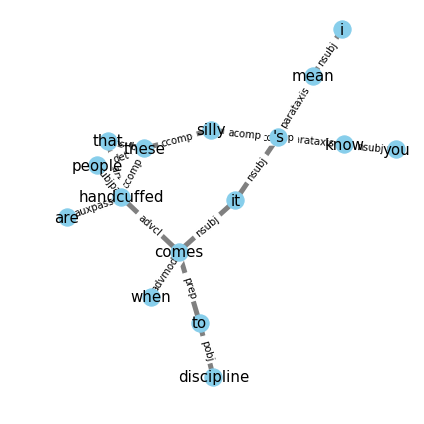

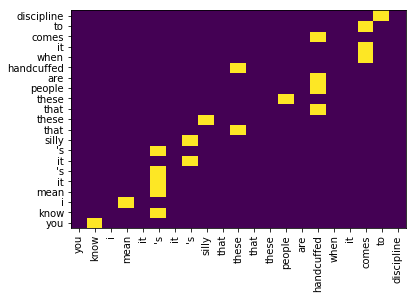

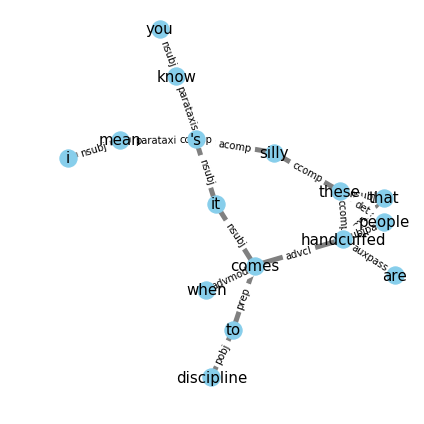

In [42]:
show_attention(model_d2, drawer_d2, attention_head=(0, 1))

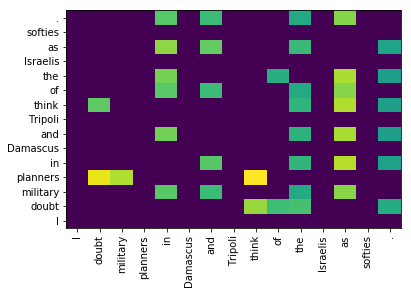

c:\users\ico\documents\works\graph-convolution-nlp\venv\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


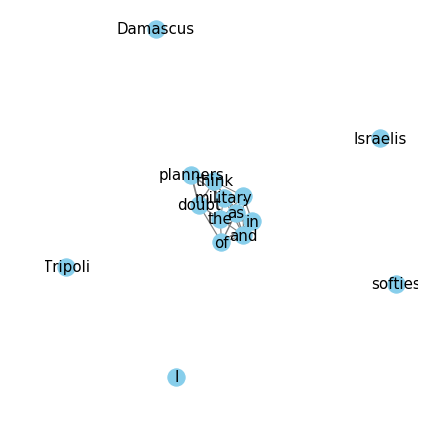

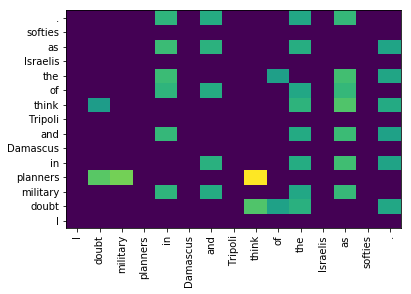

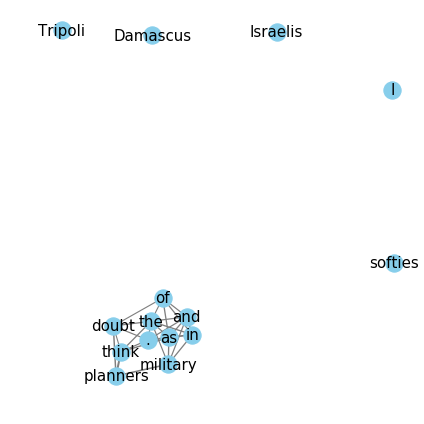

In [43]:
show_attention(model_s2, drawer_s2, attention_head=(0, 1))

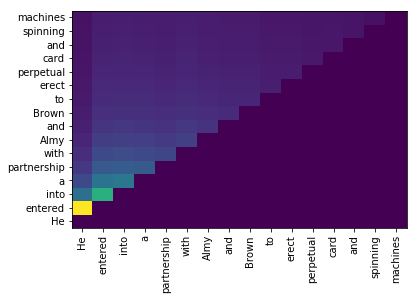

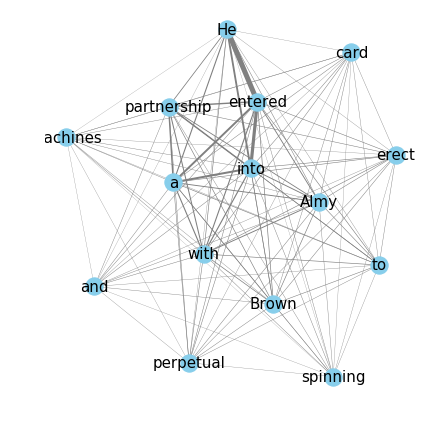

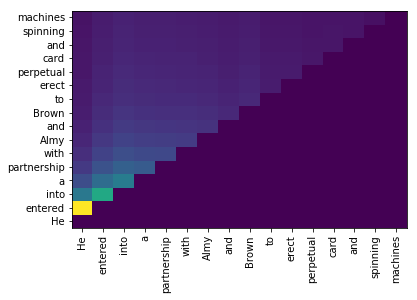

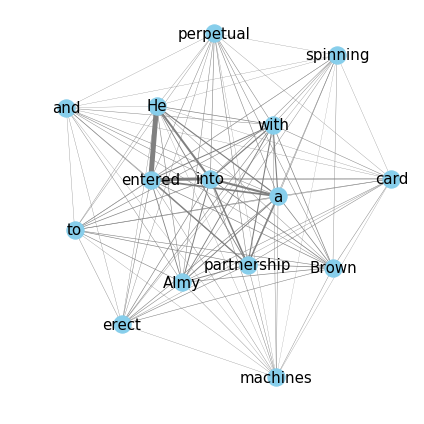

In [44]:
show_attention(model_st2, drawer_st2, attention_head=(0, 1))